# **Hierarchical clustering on seed data**
Overview:

step1: the UCI seed dataset from https://archive.ics.uci.edu/ml/datasets/seeds 

step1: standardize the features using StandardScaler

step3: Find the optimal number of clustures to be formed k using elbow method

step4: Apply hierarchical clustering and divide data into k clusters and assign label to each datapoint

step5: Apply KNN on new dataset i.e after assigning a clusture with the clusturing

step6: Apply knn on original dataset and comapere both the results

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from statistics import mode

In [11]:
# Load and preprocess data
df = pd.read_csv("seeds_dataset.txt", sep="\s+", header=None) 
X = df.iloc[:, :-1].values # features
y = df.iloc[:, -1].values # labels
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Elbow method**

c:\Users\gouth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gouth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gouth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gouth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

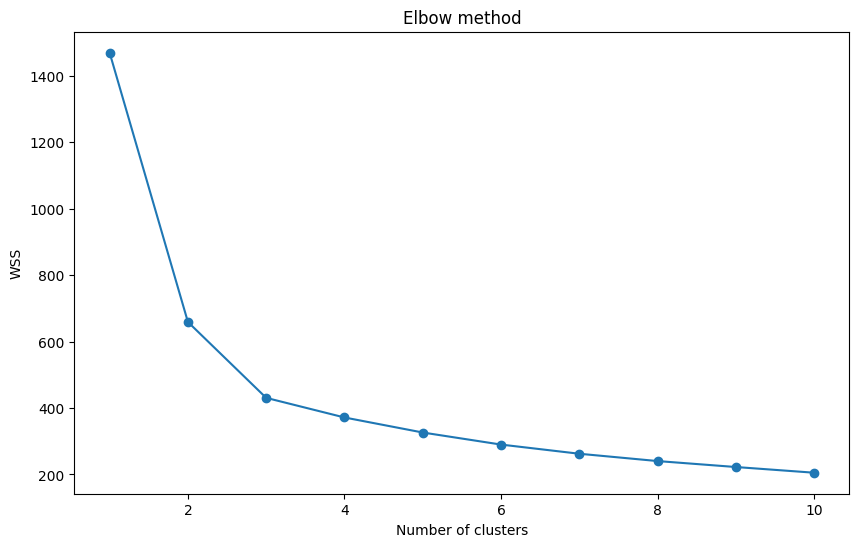

In [12]:
# Calculate wss for different values of k
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

# Plot wss against k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wss, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("WSS")
plt.title("Elbow method")
plt.show()

**Code for *hierarchical_clustering* bottom up**

In [13]:
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

def distance_matrix(X):
    n = X.shape[0] # number of data points
    D = np.zeros((n, n)) # initialize distance matrix
    for i in range(n):
        for j in range(i+1, n):
            D[i, j] = euclidean_distance(X[i], X[j]) # fill upper triangle with distances
            D[j, i] = D[i, j] # fill lower triangle with same distances (symmetric matrix)
    return D

def closest_clusters(D):
    if np.any(D): # check if distance matrix has any non-zero values
        min_dist = np.min(D[np.nonzero(D)]) # find minimum non-zero distance
        i, j = np.where(D == min_dist) # find indices of minimum distance
        return i[0], j[0] # return first pair of indices
    else:
        raise ValueError("Invalid distance matrix: zero-size array") # raise an error if distance matrix is empty or all zeros

def merge_clusters(X1, X2, linkage):
    if linkage: 
        X = np.concatenate((X1, X2), axis=0) # join arrays along rows
    else:
        raise ValueError("Invalid linkage criterion")
    return X

# Define update distance matrix function
def update_distance_matrix(D, i, j, linkage):
    n = D.shape[0] # number of clusters
    u = n # index of the new cluster
    D = np.vstack((D, np.zeros(n))) # add a new row for the new cluster
    D = np.hstack((D, np.zeros((n+1, 1)))) # add a new column for the new cluster
    for k in range(n): # iterate over the remaining clusters
        if linkage == "single": # use single linkage method
            D[u][k] = min(D[i][k], D[j][k]) # update row u
            D[k][u] = min(D[k][i], D[k][j]) # update column u
        elif linkage == "complete": # use complete linkage method
            D[u][k] = max(D[i][k], D[j][k]) # update row u
            D[k][u] = max(D[k][i], D[k][j]) # update column u
        elif linkage == "average": # use average linkage method
            D[u][k] = (D[i][k] + D[j][k]) / 2 # update row u
            D[k][u] = (D[k][i] + D[k][j]) / 2 # update column u
        # elif linkage == "ward": # use ward linkage method 
        #     ni = np.sum(D[i] != 0) # number of elements in cluster i 
        #     nj = np.sum(D[j] != 0) # number of elements in cluster j 
        #     nu = ni + nj # number of elements in cluster u 
        #     D[u][k] = (ni * D[i][k] + nj * D[j][k] - nu * np.sqrt(D[i][k] * D[j][k])) / (ni + nj) # update row u using Ward’s formula 
        #     D[k][u] = (ni * D[k][i] + nj * D[k][j] - nu * np.sqrt(D[k][i] * D[k][j])) / (ni + nj) # update column u using Ward’s formula
        else:
            raise ValueError("Invalid linkage method")
    D = np.delete(D, (i, j), axis=0) # delete rows i and j
    D = np.delete(D, (i, j), axis=1) # delete columns i and j
    return D

def hierarchical_clustering(X, n_clusters=3, linkage="single"):
    n = X.shape[0] # number of data points
    C = [np.array([x]) for x in X] # initialize clusters as singletons
    D = distance_matrix(X)
    Z = []
    cluster_ids = np.arange(n)
    while len(C)>n_clusters:
        i, j = closest_clusters(D) # find closest pair of clusters
        t=merge_clusters(C[i], C[j], linkage)
        C.append(t) # merge them into a new cluster
        C.pop(max(i,j)) # remove the merged clusters from the list
        C.pop(min(i,j)) 
        # Z.append([i, j, np.max(D[i, :]), len(t)])  # update linkage matrix
        # cluster_ids = np.append(cluster_ids, cluster_ids.max() + 1)  # assign new cluster ID
        # cluster_ids[C[i]] = cluster_ids.max()  # update cluster IDs of merged clusters
        # cluster_ids[C[j]] = cluster_ids.max()
        D = update_distance_matrix(D,i,j,linkage)
        
    return C

In [14]:
def create_datasets(y_pred):
  for idx,val in enumerate(y_pred):
      o_temp=[]
      for i in val:
          temp=[]
          for j in i:
              temp.append(j)
          temp.append(idx)
          y_labels.append(idx)
          o_temp.append(temp)
          temp=[]
      new.append(o_temp)
      o_temp=[]

  for idx,val in enumerate(y_pred):
      for i in val:
          big.append(i)

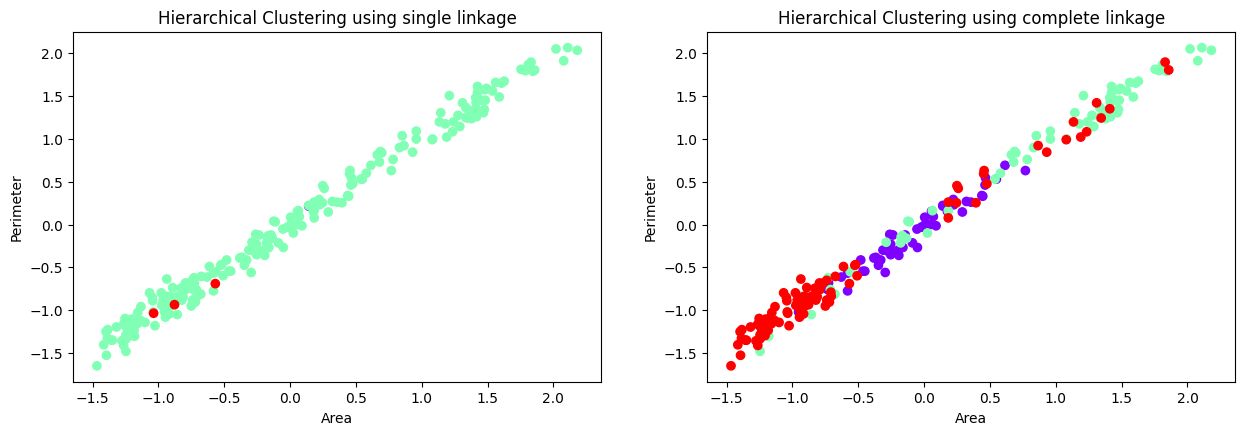

In [15]:
# methods = ["single", "complete", "average"]
methods = ["single", "complete"]

plt.figure(figsize=(15, 10))
for i, method in enumerate(methods):
    # Compute the linkage matrix
    new=[]
    big=[]
    y_labels=[]
    # Z = linkage(X, method=method)
    y_pred=hierarchical_clustering(X, 3, method)
    # Plot the dendrogram
    create_datasets(y_pred)
    plt.subplot(2, 2, i+1)
    plt.title(f"Hierarchical Clustering using {method} linkage")
    plt.scatter(X[:, 0], X[:, 1], c=y_labels, cmap="rainbow")
    plt.xlabel("Area")
    plt.ylabel("Perimeter")
    # plt.title("Hierarchical Clustering on Seed Dataset")
plt.show()
x_train=big

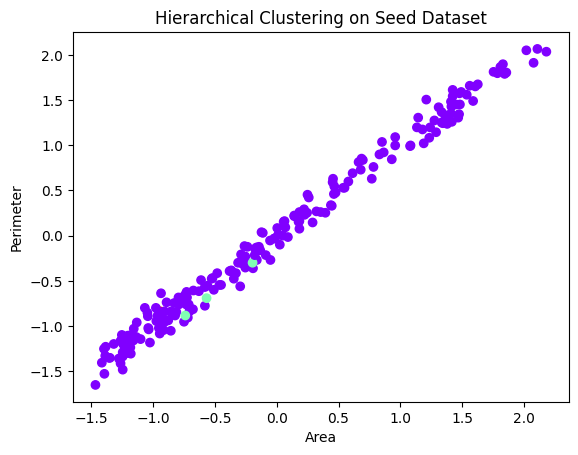

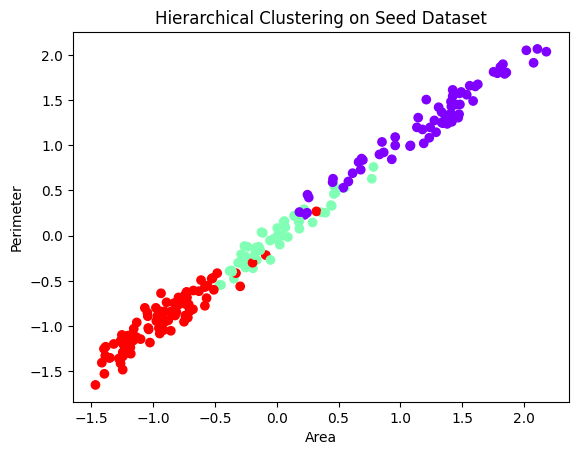

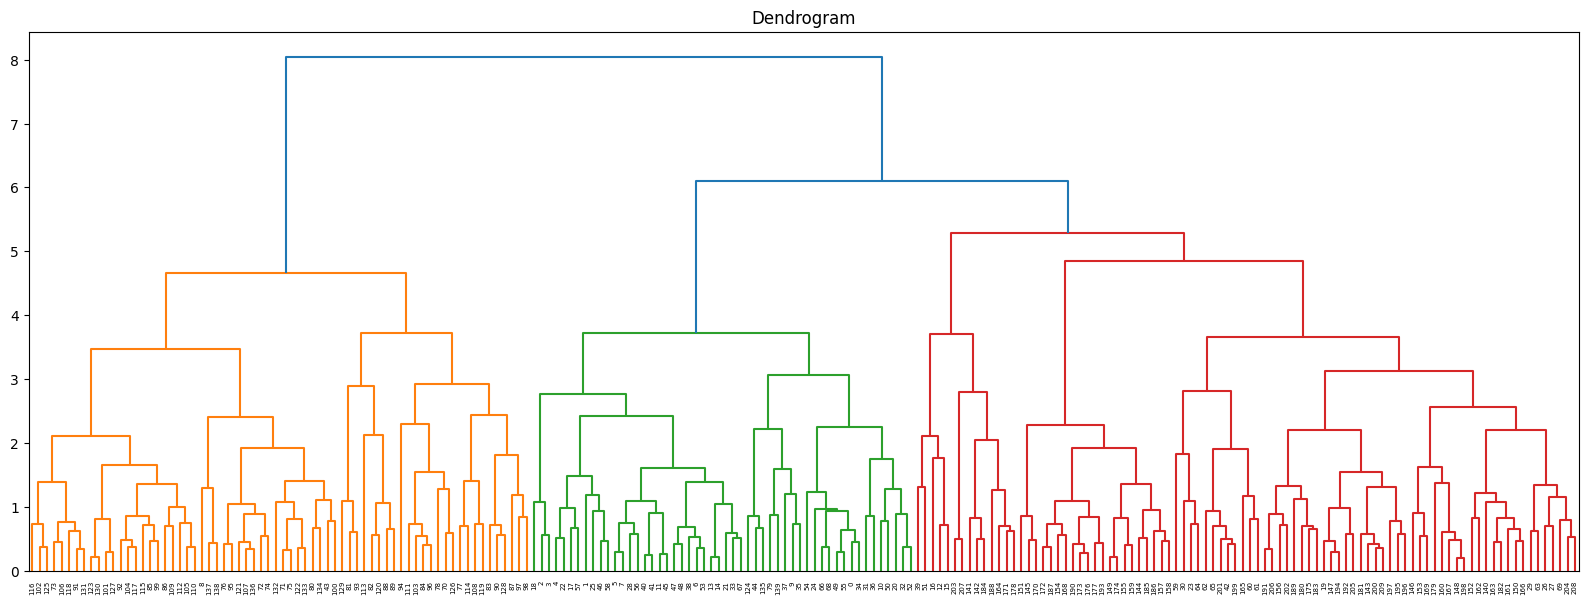

Accuracy: 0.9428571428571428


In [16]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load and preprocess data
df = pd.read_csv("seeds_dataset.txt", sep="\s+", header=None) 
X = df.iloc[:, :-1].values # features
y = df.iloc[:, -1].values # labels
scaler = StandardScaler()
X = scaler.fit_transform(X)

# # Perform hierarchical clustering
distance_matrix = shc.linkage(X, method="single", metric="euclidean")


# Choose number of clusters and assign labels
n_clusters = 3 # based on visual inspection of dendrogram
cluster_labels = shc.fcluster(distance_matrix, n_clusters, criterion="maxclust")
# X = np.c_[X, cluster_labels] # add cluster labels as features

plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap="rainbow")
plt.xlabel("Area")
plt.ylabel("Perimeter")
plt.title("Hierarchical Clustering on Seed Dataset")
plt.show()

distance_matrix = shc.linkage(X, method="complete", metric="euclidean")
cluster_labels = shc.fcluster(distance_matrix, n_clusters, criterion="maxclust")
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap="rainbow")
plt.xlabel("Area")
plt.ylabel("Perimeter")
plt.title("Hierarchical Clustering on Seed Dataset")
plt.show()

# distance_matrix = shc.linkage(X, method="average", metric="euclidean")
# cluster_labels = shc.fcluster(distance_matrix, n_clusters, criterion="maxclust")
# plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap="rainbow")
# plt.xlabel("Area")
# plt.ylabel("Perimeter")
# plt.title("Hierarchical Clustering on Seed Dataset")
# plt.show()

plt.figure(figsize=(20, 7))
plt.title("Dendrogram")
shc.dendrogram(distance_matrix)
plt.axhline(y=10, color="r", linestyle="--")
plt.show()
X = np.c_[X, cluster_labels] # add cluster labels as features

# Train and test k-nearest classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
y_pred = knn.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")


big2=[]
for i in new:
    for j in i:
        big2.append(j)

train_X=big2





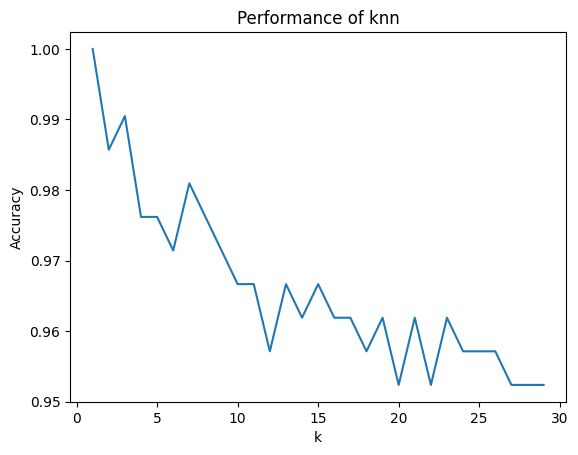

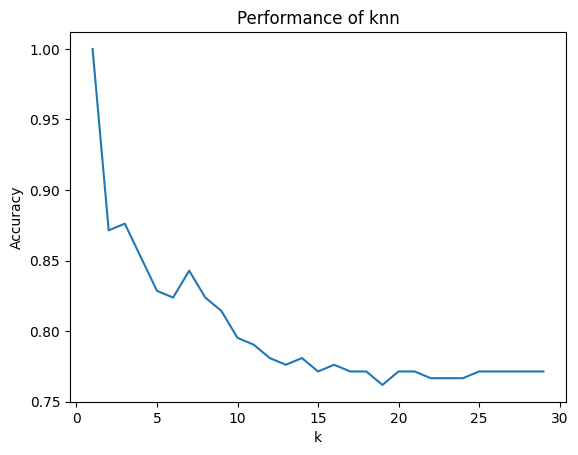

In [17]:
def most_common(lst):
    return max(set(lst), key=lst.count)
def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KNeighborsClassifier:
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])
        return list(map(most_common, neighbors))
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        correct = (y_pred == y_test)
        num_correct=0
        for i,j in zip(y_pred,y_test):
            if i==j:
                num_correct+=1
    # Divide by the total number of predictions
        accuracy = num_correct / len(y_test)
        # accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy
# Unpack the iris dataset, from UCI Machine Learning Repository

# Test knn model across varying ks
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(x_train, y_labels)
    accuracy = knn.evaluate(x_train, y_labels)
    accuracies.append(accuracy)
    # print(accuracy)
# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()
from sklearn.neighbors import KNeighborsClassifier
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y_labels)
    y_pred = knn.predict(X)
    accuracy = accuracy_score(y_labels, y_pred)
    # print(f"Accuracy: {accuracy}")
    # knn = KNeighborsClassifier(k=k)
    # knn.fit(x_train, y_labels)
    # accuracy = knn.evaluate(x_train, y_labels)
    accuracies.append(accuracy)
    # print(accuracy)
# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()

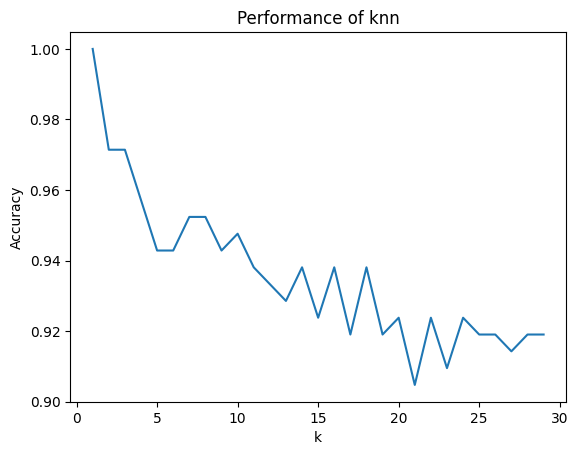

In [18]:
from sklearn.neighbors import KNeighborsClassifier
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    accuracy = accuracy_score(y, y_pred)
    accuracies.append(accuracy)
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()